<a href="https://colab.research.google.com/github/Morteza-Waskasi/Add-dummy-atom-orientational-order-parameters-p1-p2-and-p21-and-tetrahedral-order-parameter-Q/blob/master/stl10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and installing packages

In [106]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import tensorflow as tf
import keras.utils
from keras import utils as np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc
from __future__ import print_function
import sys
import os, sys, tarfile, errno
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tsne import bh_sne
%matplotlib inline
from sklearn.manifold import TSNE
from keras.utils import np_utils


!pip install PyDrive
!pip install tsne
!pip install np_utils
!pip install pyunpack
!pip install patool
!pip install -U -q PyDrive

# Loading and cleaning data

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
link = 'https://drive.google.com/open?id=1zjd8r30XBGYObNOXPuODhpeK4eny_wbO' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='


In [0]:
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('stl10_binary.tar')

In [10]:
!ls

adc.json  sample_data  stl10_binary  stl10_binary.tar


In [11]:
! pwd

/content


In [73]:
from pyunpack import Archive
Archive('stl10_binary.tar').extractall('/content/')
!tar -xvf stl10_binary.tar

stl10_binary/
stl10_binary/train_y.bin
stl10_binary/class_names.txt
stl10_binary/test_y.bin
stl10_binary/unlabeled_X.bin
stl10_binary/test_X.bin
stl10_binary/train_X.bin
stl10_binary/fold_indices.txt


In [74]:
! ls 

adc.json		      model.best.hdf5  stl10_binary.tar
inception_features_test.npz   sample_data      tsne_features.npz
inception_features_train.npz  stl10_binary


In [75]:
! ls stl10_binary/*

stl10_binary/class_names.txt   stl10_binary/train_X.bin
stl10_binary/fold_indices.txt  stl10_binary/train_y.bin
stl10_binary/test_X.bin        stl10_binary/unlabeled_X.bin
stl10_binary/test_y.bin


In [0]:
train_X= np.fromfile('stl10_binary/train_X.bin', dtype=np.uint8)
train_y= np.fromfile('stl10_binary/train_y.bin', dtype=np.uint8)
test_X= np.fromfile('stl10_binary/test_X.bin', dtype=np.uint8)
test_y= np.fromfile('stl10_binary/test_y.bin', dtype=np.uint8)

In [77]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(138240000,)
(5000,)
(221184000,)
(8000,)


In [0]:
Im_train_X=np.reshape(train_X,(-1,3,96,96))
Im_test_X=np.reshape(test_X,(-1,3,96,96))

In [79]:
print(Im_train_X.shape)
print(Im_test_X.shape)

(5000, 3, 96, 96)
(8000, 3, 96, 96)


In [0]:
Im_train_X = np.transpose(Im_train_X, (0, 3, 2, 1))
Im_test_X = np.transpose(Im_test_X, (0, 3, 2, 1))
#train_y=np.reshape(train_y,(len(train_y),1))
#test_y=np.reshape(test_y,(len(test_y),1))


In [81]:
print(Im_train_X.shape)
print(train_y.shape)
print(Im_test_X.shape)
print(test_y.shape)

(5000, 96, 96, 3)
(5000,)
(8000, 96, 96, 3)
(8000,)


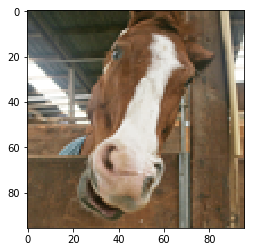

In [82]:
    plt.imshow(Im_train_X[11])
   # plt.imshow(Im_test_X[1000])
    plt.show()

In [83]:
print(Im_train_X[1][1][1])
print(Im_test_X[1][1][1])

[124 133  71]
[92 79 72]


In [0]:

Im_train_X = Im_train_X.astype('float32') / 255
Im_test_X = Im_test_X.astype('float32') / 255

In [85]:
print(Im_train_X[1][1][1])
print(Im_test_X[1][1][1])

[0.4862745  0.52156866 0.2784314 ]
[0.36078432 0.30980393 0.28235295]


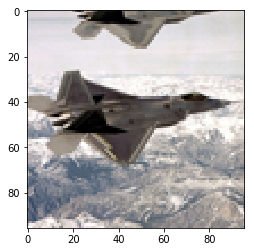

In [86]:
    #plt.imshow(Im_train_X[10])
    plt.imshow(Im_train_X[12])
    #plt.imshow(Im_test_X[1000])
    plt.show()

In [0]:
from keras.utils import to_categorical
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

In [88]:
print(Im_train_X.shape)
print(train_y.shape)
print(Im_test_X.shape)
print(test_y.shape)

(5000, 96, 96, 3)
(5000, 11)
(8000, 96, 96, 3)
(8000, 11)


In [89]:
np.max(train_y[:][:,0])

0.0

In [0]:
train_y=train_y[:][:,1:11]
test_y=test_y[:][:,1:11]

In [91]:
print(Im_train_X.shape)
print(train_y.shape)
print(Im_test_X.shape)
print(test_y.shape)

(5000, 96, 96, 3)
(5000, 10)
(8000, 96, 96, 3)
(8000, 10)


Selecting 2000 data points of the training set.

In [0]:
#train_y=train_y[:][:1000,:]
#test_y=test_y[:][:1000,:]
#Im_train_X=Im_train_X[:][:1000,:]
#Im_test_X=Im_test_X[:][:1000,:]

# Covolutional Neural Network

In [0]:
from keras.models import Sequential
model = Sequential()

In [0]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [0]:
model.add(Conv2D(filters=16, 
                kernel_size=(3, 3),
                activation='relu',
                input_shape=(96, 96, 3)))

In [0]:
model.add(MaxPool2D())

In [0]:
model.add(Conv2D(filters=32,
                kernel_size=(3, 3),
                activation='relu'))
model.add(MaxPool2D())

In [0]:
model.add(Conv2D(filters=64,
                kernel_size=(3, 3),
                activation='relu'))
model.add(MaxPool2D())

In [0]:
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [0]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [100]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 94, 94, 16)        448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
__________

In [101]:
history = model.fit(Im_train_X, train_y, batch_size=64, epochs=45, verbose=1, validation_data=(Im_test_X, test_y))

Train on 5000 samples, validate on 8000 samples
Epoch 1/45
5000/5000 [==============================] - 8s 2ms/step - loss: 1.8830 - acc: 0.3046 - val_loss: 1.6539 - val_acc: 0.4045
Epoch 2/45
5000/5000 [==============================] - 5s 1ms/step - loss: 1.4792 - acc: 0.4514 - val_loss: 1.4514 - val_acc: 0.4714
Epoch 3/45
5000/5000 [==============================] - 5s 1ms/step - loss: 1.3278 - acc: 0.5210 - val_loss: 1.3746 - val_acc: 0.5006
Epoch 4/45
5000/5000 [==============================] - 5s 1ms/step - loss: 1.2157 - acc: 0.5618 - val_loss: 1.3714 - val_acc: 0.4999
Epoch 5/45
5000/5000 [==============================] - 5s 1ms/step - loss: 1.1023 - acc: 0.6052 - val_loss: 1.2830 - val_acc: 0.5426
Epoch 6/45
5000/5000 [==============================] - 5s 1ms/step - loss: 0.9839 - acc: 0.6486 - val_loss: 1.2279 - val_acc: 0.5679
Epoch 7/45
5000/5000 [==============================] - 5s 1ms/step - loss: 0.8866 - acc: 0.6880 - val_loss: 1.2988 - val_acc: 0.5530
Epoch 8/45
500

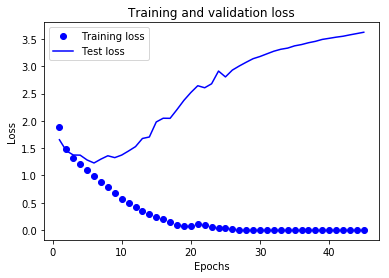

In [102]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 96x96 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 10 output neurons. It will contain a value from 0-10 for all classes.
    tf.keras.layers.Dense(10, activation='softmax')  
])

In [104]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 94, 94, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
__________

In [0]:
model.compile(optimizer=RMSprop(lr=0.001),
              loss='categorical_crossentropy',
              metrics = ['acc'])

In [108]:
history = model.fit(Im_train_X, train_y, batch_size=50, epochs=15, verbose=1, validation_data=(Im_test_X, test_y))

Train on 5000 samples, validate on 8000 samples
Epoch 1/15
5000/5000 [==============================] - 7s 1ms/sample - loss: 1.8998 - acc: 0.2952 - val_loss: 1.6484 - val_acc: 0.3849
Epoch 2/15
5000/5000 [==============================] - 6s 1ms/sample - loss: 1.5001 - acc: 0.4486 - val_loss: 1.3857 - val_acc: 0.4860
Epoch 3/15
5000/5000 [==============================] - 6s 1ms/sample - loss: 1.2949 - acc: 0.5316 - val_loss: 1.3102 - val_acc: 0.5194
Epoch 4/15
5000/5000 [==============================] - 6s 1ms/sample - loss: 1.0841 - acc: 0.6078 - val_loss: 1.2991 - val_acc: 0.5311
Epoch 5/15
5000/5000 [==============================] - 5s 1ms/sample - loss: 0.8899 - acc: 0.6816 - val_loss: 1.4020 - val_acc: 0.5129
Epoch 6/15
5000/5000 [==============================] - 5s 1ms/sample - loss: 0.7129 - acc: 0.7516 - val_loss: 1.2553 - val_acc: 0.5741
Epoch 7/15
5000/5000 [==============================] - 5s 1ms/sample - loss: 0.5317 - acc: 0.8210 - val_loss: 1.6604 - val_acc: 0.5349


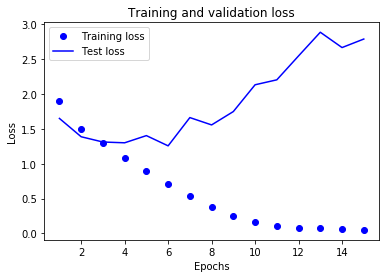

In [109]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Applying Augmentation to avoid overfitting

In [110]:
print(Im_train_X.shape)
print(train_y.shape)
print(Im_test_X.shape)
print(test_y.shape)

(5000, 96, 96, 3)
(5000, 10)
(8000, 96, 96, 3)
(8000, 10)


In [0]:
train_X= np.fromfile('stl10_binary/train_X.bin', dtype=np.uint8)
train_y= np.fromfile('stl10_binary/train_y.bin', dtype=np.uint8)
test_X= np.fromfile('stl10_binary/test_X.bin', dtype=np.uint8)
test_y= np.fromfile('stl10_binary/test_y.bin', dtype=np.uint8)
########################
Im_train_X=np.reshape(train_X,(-1,3,96,96))
Im_test_X=np.reshape(test_X,(-1,3,96,96))
##################################
Im_train_X = np.transpose(Im_train_X, (0, 3, 2, 1))
Im_test_X = np.transpose(Im_test_X, (0, 3, 2, 1))
#train_y=np.reshape(train_y,(len(train_y),1))
#test_y=np.reshape(test_y,(len(test_y),1))

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    rescale=1. / 255)


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(26, activation=tf.nn.softmax)])

model.compile(optimizer = tf.train.AdamOptimizer(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [117]:
history = model.fit_generator(train_datagen.flow(Im_train_X, train_y, batch_size=32),
                              steps_per_epoch=len(Im_train_X) / 32,
                              epochs=20,
                              validation_data=validation_datagen.flow(Im_test_X, test_y, batch_size=32),
                              validation_steps=len(Im_test_X) / 32)

model.evaluate(Im_test_X, test_y)

Epoch 1/20
157/157 [==============================] - 20s 125ms/step - loss: 1.9979 - acc: 0.2516 - val_loss: 1.6481 - val_acc: 0.3790
Epoch 2/20
157/157 [==============================] - 18s 117ms/step - loss: 1.7564 - acc: 0.3310 - val_loss: 1.6363 - val_acc: 0.3932
Epoch 3/20
157/157 [==============================] - 19s 118ms/step - loss: 1.6662 - acc: 0.3590 - val_loss: 1.4634 - val_acc: 0.4539
Epoch 4/20
157/157 [==============================] - 18s 117ms/step - loss: 1.6063 - acc: 0.3998 - val_loss: 1.4143 - val_acc: 0.4734
Epoch 5/20
157/157 [==============================] - 18s 117ms/step - loss: 1.5437 - acc: 0.4238 - val_loss: 1.4017 - val_acc: 0.4650
Epoch 6/20
157/157 [==============================] - 19s 122ms/step - loss: 1.5067 - acc: 0.4388 - val_loss: 1.3564 - val_acc: 0.4980
Epoch 7/20
157/157 [==============================] - 19s 118ms/step - loss: 1.4867 - acc: 0.4506 - val_loss: 1.3350 - val_acc: 0.5120
Epoch 8/20
157/157 [==============================] - 1

[8.609115413665771, 0.45525]

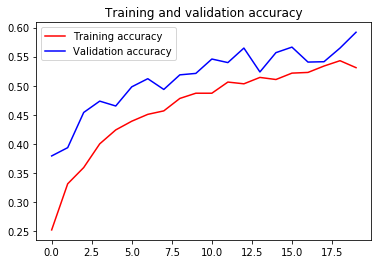

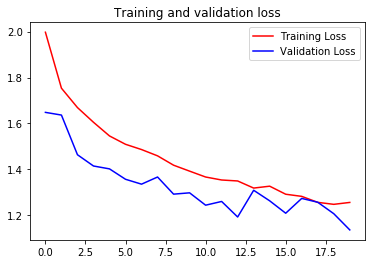

In [118]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Transfer Learning 

In [119]:
# load inceptionV3 model + remove final classification layers
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))
print('model loaded')

model loaded


In [120]:
# obtain bottleneck features (train)
if os.path.exists('inception_features_train.npz'):
    print('bottleneck features detected (train)')
    features = np.load('inception_features_train.npz')['features']
else:
    print('bottleneck features file not detected (train)')
    print('calculating now ...')
    # pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(Im_train_X[i], (139, 139, 3)) 
                            for i in range(0, len(Im_train_X))]).astype('float32')
    inception_input_train = preprocess_input(big_x_train)
    print('train data preprocessed')
    # extract, process, and save bottleneck features
    features = model.predict(inception_input_train)
    features = np.squeeze(features)
    np.savez('inception_features_train', features=features)
print('bottleneck features saved (train)')

bottleneck features detected (train)
bottleneck features saved (train)


tsne features not detected (test)
calculating now ...
tsne features obtained


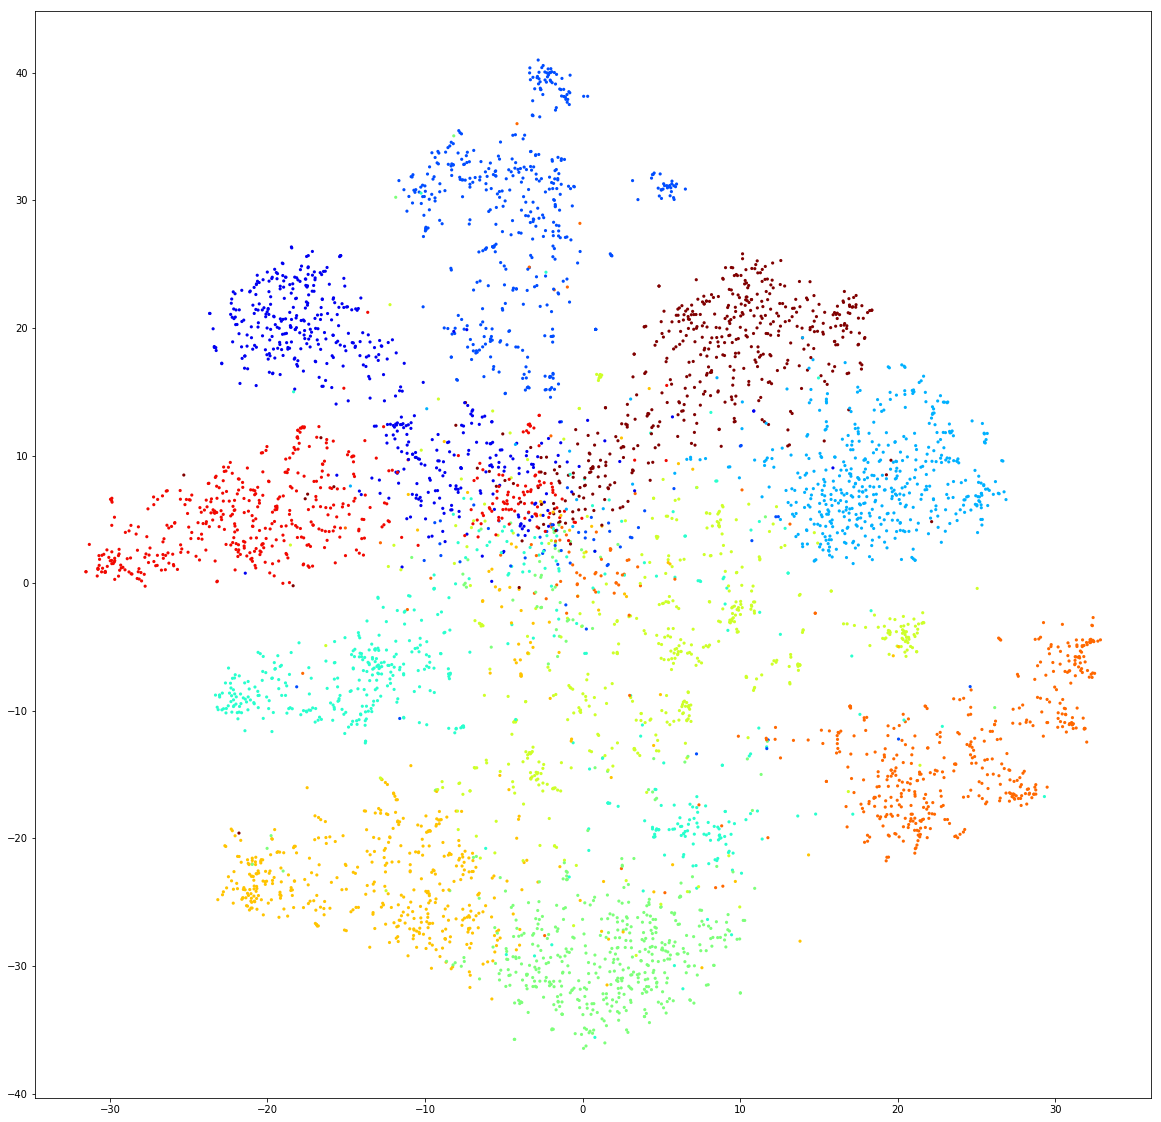

In [51]:
# reshape bottleneck features + reduce dimensionality with t-SNE
if os.path.exists('tsne_features.npz'):
    print('tsne features detected (test)')
    tsne_features = np.load('tsne_features.npz')['tsne_features']
else:
    print('tsne features not detected (test)')
    print('calculating now ...')
    tsne_features = bh_sne(features.reshape([features.shape[0], np.prod(features.shape[1:])]).astype('float64')[:25000])
    np.savez('tsne_features', tsne_features=tsne_features)
print('tsne features obtained')

# plot the features
plt.figure(figsize=(20,20))
plt.scatter(tsne_features[:,0], tsne_features[:,1], c=plt.cm.jet(train_y/10), s=10, edgecolors='none')
plt.show()

In [52]:

# obtain bottleneck features (test)
if os.path.exists('inception_features_test.npz'):
    print('bottleneck features detected (test)')
    features_test = np.load('inception_features_test.npz')['features_test']
else:
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(Im_test_X[i], (139, 139, 3)) 
                       for i in range(0, len(Im_test_X))]).astype('float32')
    inception_input_test = preprocess_input(big_x_test)
    # extract, process, and save bottleneck features (test)
    features_test = model.predict(inception_input_test)
    features_test = np.squeeze(features_test)
    np.savez('inception_features_test', features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features file not detected (test)
calculating now ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':


bottleneck features saved (test)


In [0]:
# one-hot encode the labels
train_y = np_utils.to_categorical(train_y, 11)
test_y = np_utils.to_categorical(test_y, 11)

In [0]:
train_y=train_y[:][:,1:11]
test_y=test_y[:][:,1:11]

In [123]:
print(Im_train_X.shape)
print(train_y.shape)
print(Im_test_X.shape)
print(test_y.shape)

(5000, 96, 96, 3)
(5000, 10)
(8000, 96, 96, 3)
(8000, 10)


In [124]:
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=100, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.4))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.best.hdf5', 
                               verbose=1, save_best_only=True)
history =model.fit(features, train_y, batch_size=50, epochs=100,
          validation_split=0.2, callbacks=[checkpointer],
          verbose=2, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_195 (Conv2D)          (None, 2, 2, 100)         819300    
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 2, 100)         0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 100)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 820,310
Trainable params: 820,310
Non-trainable params: 0
_________________________________________________________________
Train on 4000 samples, validate on 1000 samples
Epoch 1/100
 - 6s - loss: 6.7732 - acc: 0.5408 - val_loss: 3.3601 - val_acc: 0.7690

Epo

In [125]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.best.hdf5')

# evaluate test accuracy
score = model.evaluate(features_test, test_y, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 91.2750%


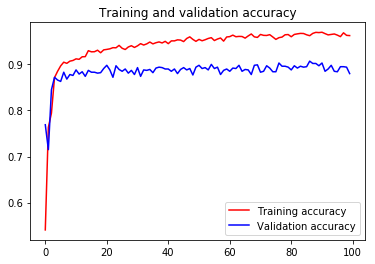

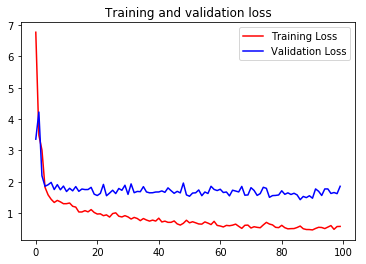

In [126]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()